In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = [15,8]

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Thesis datasets/Alcohol_Sales_Data.csv')
df.head()

,DATE,Millions of Dollars
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221


In [5]:
df.tail()

,DATE,Millions of Dollars
352,2021-05-01,15499
353,2021-06-01,17830
354,2021-07-01,15742
355,2021-08-01,16142
356,2021-09-01,15772


In [6]:
df.shape

(357, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   DATE                 357 non-null    object
 1   Millions of Dollars  357 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.7+ KB


In [8]:
df.isnull().sum()

DATE                   0
Millions of Dollars    0
dtype: int64

In [9]:
time = pd.date_range(start='1/1/1992',end='09/30/2021',freq='M')
time

DatetimeIndex(['1992-01-31', '1992-02-29', '1992-03-31', '1992-04-30',
               '1992-05-31', '1992-06-30', '1992-07-31', '1992-08-31',
               '1992-09-30', '1992-10-31',
               ...
               '2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31',
               '2021-04-30', '2021-05-31', '2021-06-30', '2021-07-31',
               '2021-08-31', '2021-09-30'],
              dtype='datetime64[ns]', length=357, freq='M')

In [10]:
len(time)

357

In [11]:
df['time_stamp'] = pd.DataFrame(time)

In [12]:
df.head()

,DATE,Millions of Dollars,time_stamp
0,1992-01-01,3459,1992-01-31
1,1992-02-01,3458,1992-02-29
2,1992-03-01,4002,1992-03-31
3,1992-04-01,4564,1992-04-30
4,1992-05-01,4221,1992-05-31


In [13]:
df.tail()

,DATE,Millions of Dollars,time_stamp
352,2021-05-01,15499,2021-05-31
353,2021-06-01,17830,2021-06-30
354,2021-07-01,15742,2021-07-31
355,2021-08-01,16142,2021-08-31
356,2021-09-01,15772,2021-09-30


In [14]:
df.drop('DATE',axis=1,inplace=True)
df = df.set_index('time_stamp')

In [19]:
df.columns=['Millions_of_Dollars']

In [20]:
df.head()

,Millions_of_Dollars
time_stamp,
1992-01-31,3459.0
1992-02-29,3458.0
1992-03-31,4002.0
1992-04-30,4564.0
1992-05-31,4221.0


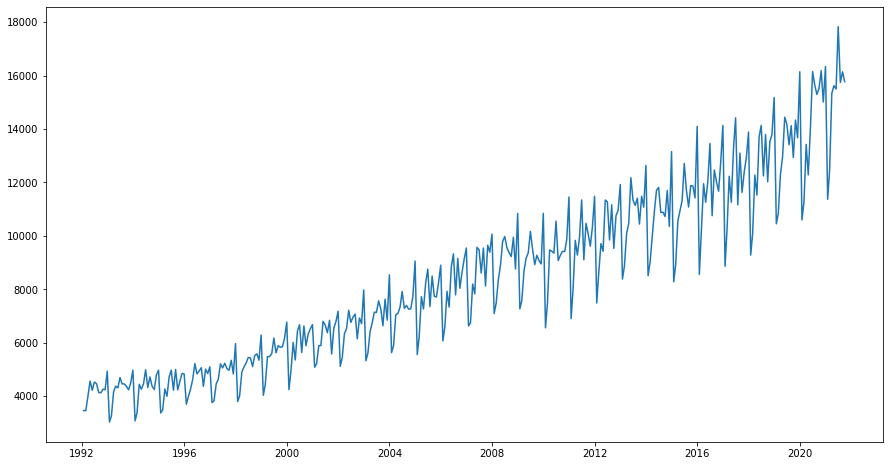

In [21]:
plt.plot(df)
plt.show()

In [22]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,])
        Y.append(data_arr[d,])
    return np.array(X), np.array(Y)

In [68]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['Millions_of_Dollars'] = df['Millions_of_Dollars'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1)) #LTSM requires more input features compared to RNN or DNN
scaler = MinMaxScaler(feature_range=(0.1, 1))#LTSM is senstive to the scale of features
df_arr = scaler.fit_transform(df_arr)

In [69]:
train_size = 310
train, test = df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
look_back = 12
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [25]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(298, 1, 12)
(298, 1)
(35, 1, 12)
(35, 1)


### Hypertuning

In [26]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 5.4 MB/s 


In [27]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Bidirectional,LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(LSTM(hp.Int('rnn_layer_1',min_value=4,max_value=40,step=4), activation="relu",input_shape=(1,look_back),recurrent_dropout = hp.Choice("recurrent_dropout",[0.2,0.4,0.6],default=0.4)))
    model.add(Dense(hp.Int('dense_layer_1',min_value=4,max_value=32,step=4),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-3, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=10,
    executions_per_trial=2,
    directory='project',
    project_name='Alcohol Sales_11')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
rnn_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 40, 'step': 4, 'sampling': None}
recurrent_dropout (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
dense_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 32, 'step': 4, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(trainX, trainY,
             epochs=500,
             batch_size=33,
             validation_data=(testX, testY))

Trial 10 Complete [00h 01m 26s]
val_mape: 5.185143709182739

Best val_mape So Far: 4.795900106430054
Total elapsed time: 00h 15m 34s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/Alcohol Sales_11
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
rnn_layer_1: 20
recurrent_dropout: 0.4
dense_layer_1: 28
Dropout_rate: 0.30000000000000004
learning_rate: 0.02570345329777908
Score: 4.795900106430054
Trial summary
Hyperparameters:
rnn_layer_1: 36
recurrent_dropout: 0.4
dense_layer_1: 28
Dropout_rate: 0.1
learning_rate: 0.005958165881034708
Score: 4.851583480834961
Trial summary
Hyperparameters:
rnn_layer_1: 36
recurrent_dropout: 0.4
dense_layer_1: 12
Dropout_rate: 0.30000000000000004
learning_rate: 0.031261669011341565
Score: 4.857815980911255
Trial summary
Hyperparameters:
rnn_layer_1: 12
recurrent_dropout: 0.2
dense_layer_1: 12
Dropout_rate: 0.0
learning_rate: 0.02512407935788564
Score: 4.888315439224243
Trial summary
Hyperparameters:
rnn_layer_1: 28
recurrent_dropout: 0.6
dense_layer_1: 28
Dropout_rate: 0.1
learning_rate: 0.053436342202688475
Score: 4.941828012466431
Trial summary
Hy

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(1, 12))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                2640      
                                                                 
 dense (Dense)               (None, 28)                588       
                                                                 
 dropout (Dropout)           (None, 28)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 29        
                                                                 
Total params: 3,257
Trainable params: 3,257
Non-trainable params: 0
_________________________________________________________________


In [31]:
from tensorflow.keras import optimizers

In [71]:
model = Sequential()
model.add(LSTM(32,activation='relu',input_shape=(1,look_back),return_sequences=True))
model.add(LSTM(32,activation='relu'))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate=0.0001384998106834072)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX, testY), batch_size = 34, epochs = 500)

Epoch 1/500
9/9 [==============================] - 4s 56ms/step - loss: 99.0004 - mape: 99.0004 - val_loss: 98.7163 - val_mape: 98.7163
Epoch 2/500
9/9 [==============================] - 0s 6ms/step - loss: 98.0201 - mape: 98.0201 - val_loss: 98.1547 - val_mape: 98.1547
Epoch 3/500
9/9 [==============================] - 0s 7ms/step - loss: 97.0691 - mape: 97.0691 - val_loss: 97.6059 - val_mape: 97.6059
Epoch 4/500
9/9 [==============================] - 0s 6ms/step - loss: 96.1377 - mape: 96.1377 - val_loss: 97.0586 - val_mape: 97.0586
Epoch 5/500
9/9 [==============================] - 0s 6ms/step - loss: 95.2177 - mape: 95.2177 - val_loss: 96.5056 - val_mape: 96.5056
Epoch 6/500
9/9 [==============================] - 0s 7ms/step - loss: 94.2637 - mape: 94.2637 - val_loss: 95.9397 - val_mape: 95.9397
Epoch 7/500
9/9 [==============================] - 0s 7ms/step - loss: 93.2934 - mape: 93.2934 - val_loss: 95.3482 - val_mape: 95.3482
Epoch 8/500
9/9 [==============================] - 0s 

In [72]:
def model_loss(history):
    plt.figure(figsize=(15,8))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [73]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 6.73 
Test MAPE : 6.76 


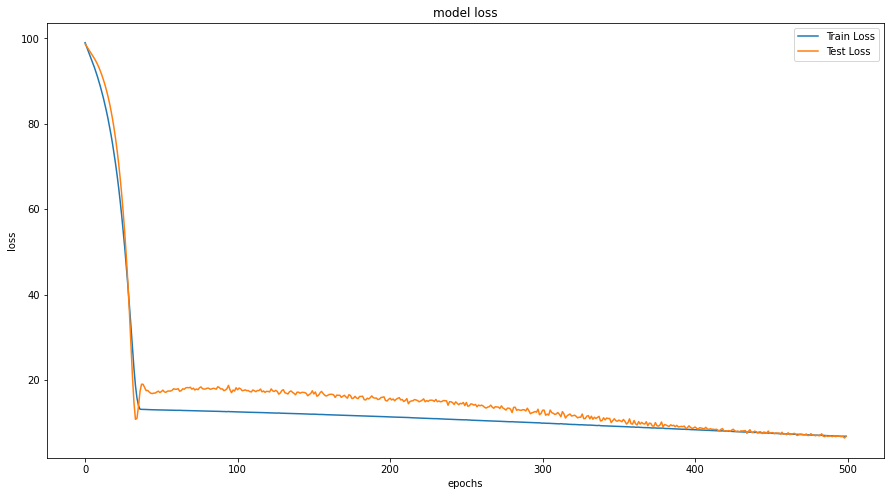

In [74]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform(trainY)
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform(testY)
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [46]:
import seaborn as sns

In [38]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(298,333)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

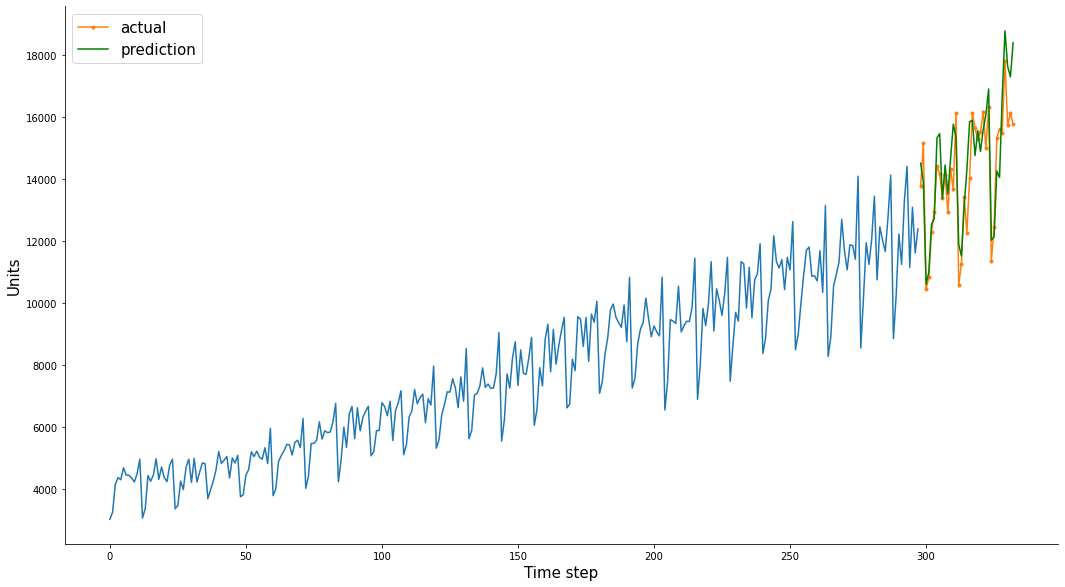

In [75]:
test_predict_scaled = model.predict(testX)
test_predict_inv = scaler.inverse_transform(test_predict_scaled)
prediction_plot(testY, test_predict_inv,look_back)